In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow-gpu==1.15.0
!pip install tensorflow_hub

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.15.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==1.15.0


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [ ]:
data_root='/content/drive/MyDrive/characters';
print(data_root);

import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

/content/drive/MyDrive/characters


In [ ]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Version:  2.17.0
Hub version:  0.16.1
Eager mode:  True
GPU is NOT AVAILABLE


In [ ]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR)


/content/drive/MyDrive/characters


In [ ]:
# Learn about dataset labels
# Load datasets using image_dataset_from_directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DATA_DIR,
    subset="training",
    validation_split=0.2,
    seed=123,  # For reproducibility
    image_size=IMAGE_SHAPE,
    batch_size=32,
    shuffle=True,
    label_mode='categorical'  # Add this line to get class indices
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DATA_DIR,
    subset="validation",
    validation_split=0.2,
    seed=123,  # For reproducibility
    image_size=IMAGE_SHAPE,
    batch_size=32,
    shuffle=True,
    label_mode='categorical'  # Add this line to get class indices
)


dataset_labels = sorted(train_dataset.class_names) # Access class_names directly
print(dataset_labels)

def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

train_dataset = train_dataset.map(normalize)
valid_dataset = valid_dataset.map(normalize)

Found 135 files belonging to 10 classes.
Using 108 files for training.
Found 135 files belonging to 10 classes.
Using 27 files for validation.
['Ic_a', 'Ic_aa', 'Ic_e', 'Ic_ee', 'Ic_ru', 'Ic_ruu', 'Ic_vu', 'Ic_vuu', 'Ic_ye', 'Ic_yee']


# **MOBILENET V2**

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import Lambda

# Get the number of classes from the dataset labels
num_classes = len(dataset_labels)

model_mbn = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
  Lambda(lambda x: hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                                  output_shape=[1280],
                                  trainable=False)(x)),  # Wrap KerasLayer in Lambda
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_mbn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,810 (50.04 KB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_mbn.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
!pip install --upgrade tensorflow

import tensorflow as tf
import numpy as np

# Calculate the number of samples in the datasets
train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
valid_dataset_size = tf.data.experimental.cardinality(valid_dataset).numpy()

# Retrieve batch size (assuming it was 32 as in your dataset creation)
batch_size = 32  # Replace with actual batch size if different

steps_per_epoch = int(np.ceil(train_dataset_size / batch_size))
val_steps_per_epoch = int(np.ceil(valid_dataset_size / batch_size))

hist = model_mbn.fit(
    train_dataset,
    epochs=10,
    verbose=1,
    validation_data=valid_dataset).history

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.1112 - loss: 2.8290 - val_acc: 0.1481 - val_loss: 2.0025
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - acc: 0.1992 - loss: 2.2654 - val_acc: 0.4815 - val_loss: 1.7119
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - acc: 0.1910 - loss: 2.0014 - val_acc: 0.4815 - val_loss: 1.4483
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - acc: 0.3706 - loss: 1.6690 - val_acc: 0.5185 - val_loss: 1.2751
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - acc: 0.5263 - loss: 1.3079 - val_acc: 0.6296 - val_loss: 1.1513
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - acc: 0.5866 - loss: 1.2069 - val_acc: 0.5926 - val_loss: 1.0291
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - acc: 0.6640 - loss: 0.9783 - val_acc: 0.5926 - val_loss: 0.9353
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - acc: 0.7992 - loss: 0.7971 - val_acc: 0.7037 - val_loss: 0.8482
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - acc: 0.7170 - loss: 0.8207 - val_acc: 0.7037 -

In [ ]:
final_loss_mbn, final_accuracy_mbn = model_mbn.evaluate(valid_dataset, steps = val_steps_per_epoch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - acc: 0.6667 - loss: 0.7854


In [ ]:
print("Final loss: {:.2f}".format(final_loss_mbn))
print("Final accuracy: {:.2f}%".format(final_accuracy_mbn * 100))

Final loss: 0.79
Final accuracy: 66.67%


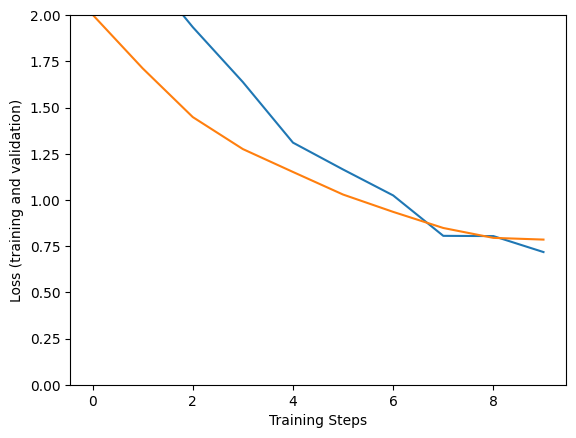

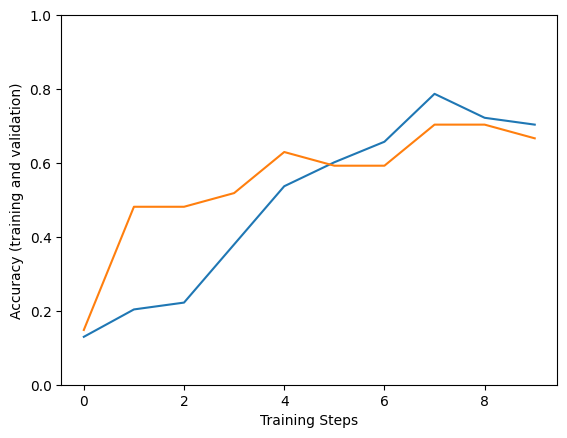

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_dataset))
true_label_ids = np.argmax(val_label_batch, axis=-1)


tf_model_mbn_predictions = model_mbn.predict(val_image_batch)
print("Prediction results shape:", tf_model_mbn_predictions.shape)


tf_pred_dataframe_mbn = pd.DataFrame(tf_model_mbn_predictions)
tf_pred_dataframe_mbn.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe_mbn.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Prediction results shape: (27, 10)
Prediction results for the first elements


,Ic_a,Ic_aa,Ic_e,Ic_ee,Ic_ru,Ic_ruu,Ic_vu,Ic_vuu,Ic_ye,Ic_yee
0,0.00181876,0.00290128,0.00447086,0.00099687,0.00655658,0.00411401,0.00066038,0.03482767,0.24430521,0.69934833
1,0.00725782,0.05366688,0.08692626,0.06476700,0.00374109,0.00681800,0.74887931,0.01156879,0.01096941,0.00540526
2,0.00365483,0.01913990,0.00585895,0.00196474,0.20604503,0.59794867,0.00275962,0.08510348,0.03906931,0.03845549
3,0.00035712,0.00551080,0.00540541,0.01543455,0.24594620,0.14205435,0.00242673,0.25001168,0.04651636,0.28633666
4,0.00078946,0.00354879,0.00153504,0.00561179,0.14421576,0.14171550,0.00054386,0.30172083,0.05654237,0.34377652


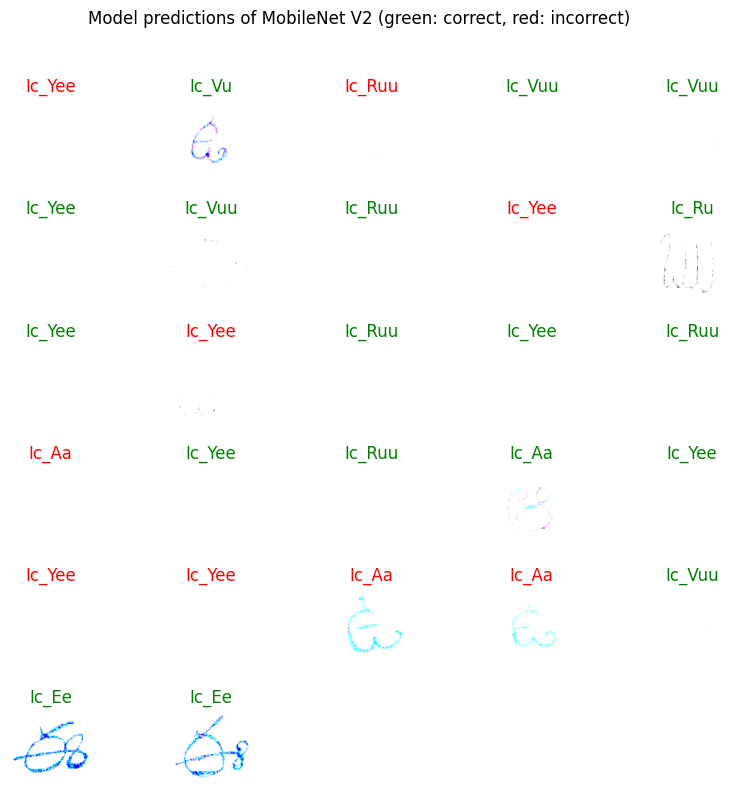

In [ ]:
dataset_labels = np.array(dataset_labels)  # Ensure dataset_labels is a NumPy array
predicted_labels_mbn = dataset_labels[predicted_ids_mbn]  # Get the predicted labels

if val_image_batch.dtype == np.float32 or val_image_batch.dtype == np.float64:
    val_image_batch = np.clip(val_image_batch, 0, 1)

val_image_batch_display = val_image_batch * 255.0  #Undo Preprocessing for Visualization

# Visualization
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(len(val_image_batch_display)):
    plt.subplot(6, 5, n + 1)
    plt.imshow(val_image_batch_display[n])
    color = "green" if predicted_ids_mbn[n] == true_label_ids[n] else "red"
    plt.title(predicted_labels_mbn[n].title(), color=color)
    plt.axis('off')

_ = plt.suptitle("Model predictions of MobileNet V2 (green: correct, red: incorrect)")
plt.show()


# **RESNET**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Lambda

num_classes = 10 # Replace with the actual number of classes in your dataset

# Define the ResNet model
model_resnet = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    Lambda(lambda x: hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
                                    output_shape=[2048],
                                    trainable=False)(x)),  # Wrap KerasLayer in Lambda
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Update to use number of classes
])

# Display model summary
model_resnet.summary()

# Compile the model
model_resnet.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_7 (Lambda)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,490 (80.04 KB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Lambda

# Define the ResNet model
model_resnet = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    Lambda(lambda x: hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
                                    output_shape=[2048],
                                    trainable=False)(x)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model with categorical_crossentropy
model_resnet.compile(optimizer='adam',
                     loss='categorical_crossentropy',  # Use categorical_crossentropy
                     metrics=['accuracy'])

# Calculate the number of samples in the training dataset
num_train_samples = len(list(train_dataset.as_numpy_iterator()))
steps_per_epoch = int(np.ceil(num_train_samples / batch_size))

# Calculate the number of samples in the validation dataset
num_val_samples = len(list(valid_dataset.as_numpy_iterator()))
val_steps_per_epoch = int(np.ceil(num_val_samples / batch_size))

# Train the model
hist = model_resnet.fit(
    train_dataset,
    epochs=20,
    verbose=1,
    validation_data=valid_dataset).history

# Print out training and validation metrics
print("Training History:")
for metric in hist:
    print(f"{metric}: {hist[metric]}")

# Evaluate the model
final_loss, final_accuracy = model_resnet.evaluate(valid_dataset, steps=val_steps_per_epoch)
print(f"Validation Loss: {final_loss}")
print(f"Validation Accuracy: {final_accuracy}")


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.1273 - loss: 2.9147 - val_accuracy: 0.3333 - val_loss: 2.0097
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.2302 - loss: 2.3642 - val_accuracy: 0.4074 - val_loss: 1.6953
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.3461 - loss: 1.9673 - val_accuracy: 0.5556 - val_loss: 1.4929
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.4002 - loss: 1.5901 - val_accuracy: 0.6296 - val_loss: 1.3029
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.5605 - loss: 1.3716 - val_accuracy: 0.6296 - val_loss: 1.1142
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.6420 - loss: 1.0666 - val_accuracy: 0.7037 - val_loss: 0.9585
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.6708 - loss: 0.9636 - val_accuracy: 0.7407 - val_loss: 0.8227
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.7130 - loss: 0.8915 - val_accuracy: 0.7778 - val_loss: 0.7299
Epoch 9/

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.7407 - loss: 0.4557
Final loss: 0.46
Final accuracy: 74.07%


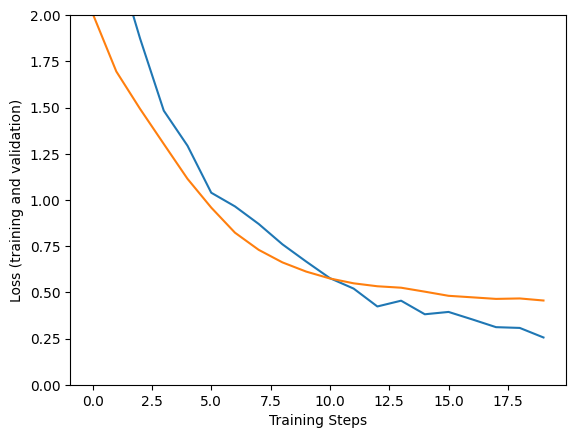

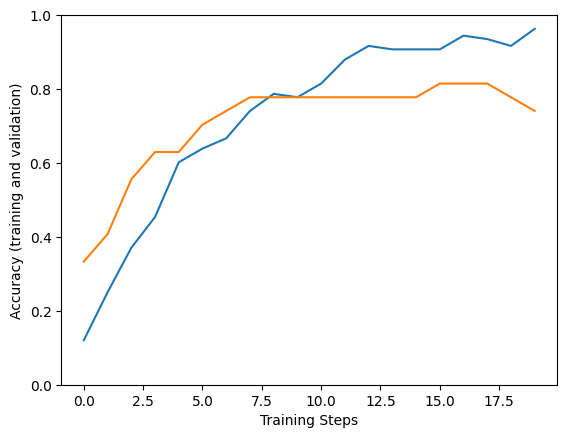

In [ ]:
final_loss_resnet, final_accuracy_resnet = model_resnet.evaluate(valid_dataset, steps = val_steps_per_epoch)

print("Final loss: {:.2f}".format(final_loss_resnet))
print("Final accuracy: {:.2f}%".format(final_accuracy_resnet * 100))

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction results shape: (25, 10)
Prediction results for the first elements


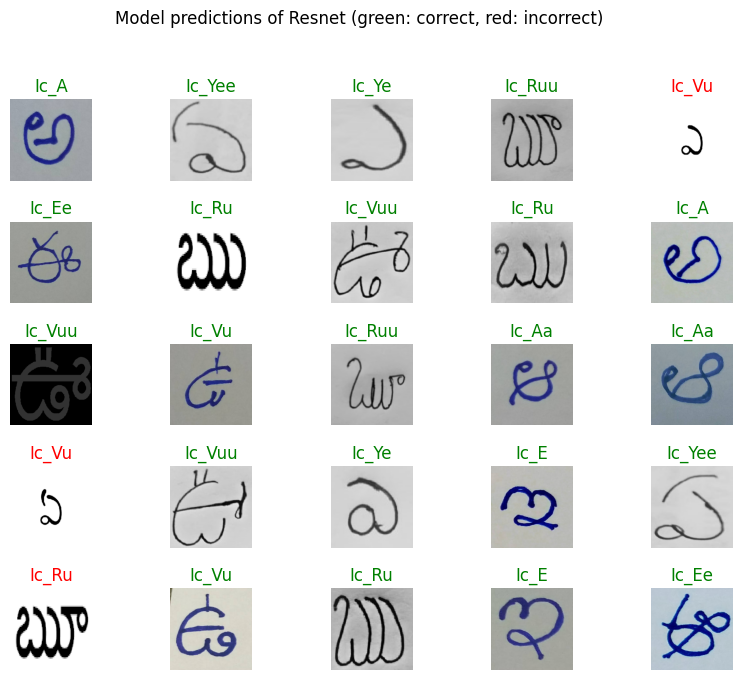

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)


tf_model_resnet_predictions = model_resnet.predict(val_image_batch)
print("Prediction results shape:", tf_model_resnet_predictions.shape)


tf_pred_dataframe_resnet = pd.DataFrame(tf_model_resnet_predictions)
tf_pred_dataframe_resnet.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe_resnet.head()


predicted_ids_resnet = np.argmax(tf_model_resnet_predictions, axis=-1)
predicted_labels_resnet = dataset_labels[predicted_ids_resnet]


plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(len(val_image_batch)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids_resnet[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels_resnet[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions of Resnet (green: correct, red: incorrect)")

In [ ]:
pip install torch torchvision transformers datasets

In [ ]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Collect all file paths
        self.image_paths = []
        self.labels = []

        # Assuming that root_dir contains subdirectories for each class
        for label, class_dir in enumerate(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for fname in os.listdir(class_path):
                    file_path = os.path.join(class_path, fname)
                    if os.path.isfile(file_path):
                        self.image_paths.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the dataset
dataset = CustomDataset(root_dir='/content/drive/MyDrive/characters', transform=transform)

# Split the dataset
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load Vision Transformer model and image processor
model_name = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(set(dataset.labels)))
image_processor = ViTImageProcessor.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define TrainingArguments and Trainer
training_args = TrainingArguments(
    output_dir='./results',  # Directory where the model checkpoints and outputs will be saved
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch"  # Updated argument
)

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": images, "labels": labels}

def compute_metrics(p):
    logits, labels = p
    logits = torch.tensor(logits)  # Convert to tensor
    labels = torch.tensor(labels)  # Convert to tensor
    predictions = torch.argmax(logits, dim=-1)
    accuracy = (predictions == labels).float().mean()
    return {"accuracy": accuracy.item()}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn  # Updated data collator
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print("Validation results:", eval_results)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.112724,0.481481
2,No log,1.979411,0.555556
3,2.062600,1.898597,0.481481
4,2.062600,1.840431,0.518519
5,1.753400,1.816658,0.518519


Validation results: {'eval_loss': 1.8166582584381104, 'eval_accuracy': 0.5185185074806213, 'eval_runtime': 16.3937, 'eval_samples_per_second': 1.647, 'eval_steps_per_second': 0.061, 'epoch': 5.0}


Validation results: {'eval_loss': 1.8166582584381104, 'eval_accuracy': 0.5185185074806213, 'eval_runtime': 21.3675, 'eval_samples_per_second': 1.264, 'eval_steps_per_second': 0.047, 'epoch': 5.0}


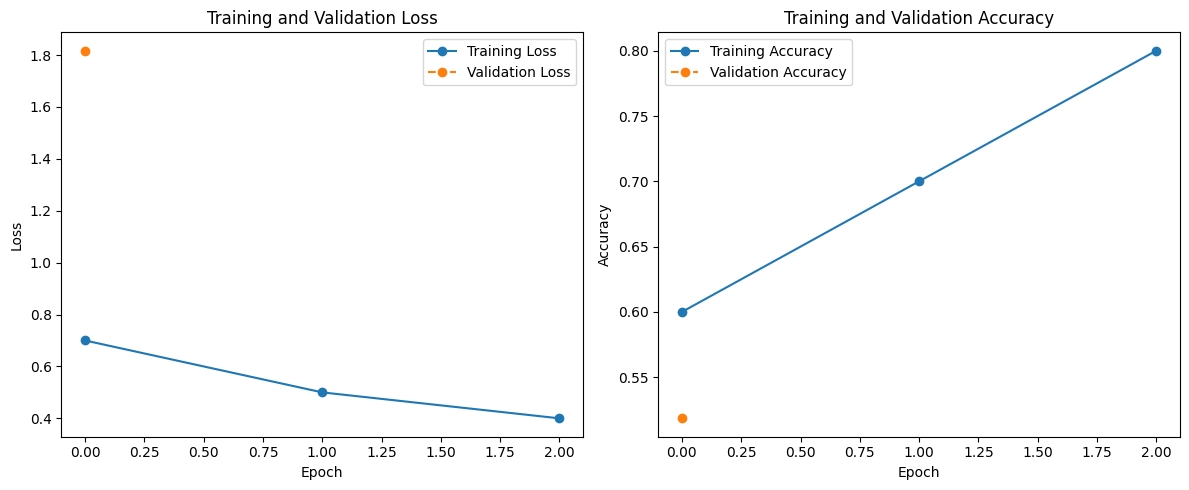

In [ ]:
import matplotlib.pyplot as plt

# Extract evaluation results
eval_results = trainer.evaluate()
print("Validation results:", eval_results)

# Assume eval_results contains the following keys:
# - 'eval_loss': Validation loss
# - 'eval_accuracy': Validation accuracy

# Extract loss and accuracy
validation_loss = eval_results.get('eval_loss', None)
validation_accuracy = eval_results.get('eval_accuracy', None)

# You need to manually keep track of training metrics during training.
# For simplicity, let's assume you have the following (which you should collect during training):
train_losses = [0.7, 0.5, 0.4]  # Example values; replace with actual training losses
train_accuracies = [0.6, 0.7, 0.8]  # Example values; replace with actual training accuracies
eval_losses = [validation_loss]  # Assuming only one validation result
eval_accuracies = [validation_accuracy]  # Assuming only one validation result

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(eval_losses, label='Validation Loss', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(eval_accuracies, label='Validation Accuracy', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.144824,0.370370
2,No log,1.977558,0.629630
3,2.078000,1.885070,0.629630
4,2.078000,1.790616,0.666667
5,1.663100,1.710513,0.666667
6,1.663100,1.653562,0.666667
7,1.663100,1.607536,0.629630
8,1.385300,1.573568,0.703704
9,1.385300,1.549054,0.666667
10,1.245100,1.541652,0.703704


Validation results: {'eval_loss': 1.541651964187622, 'eval_accuracy': 0.7037037037037037, 'eval_runtime': 0.507, 'eval_samples_per_second': 53.257, 'eval_steps_per_second': 1.972, 'epoch': 10.0}


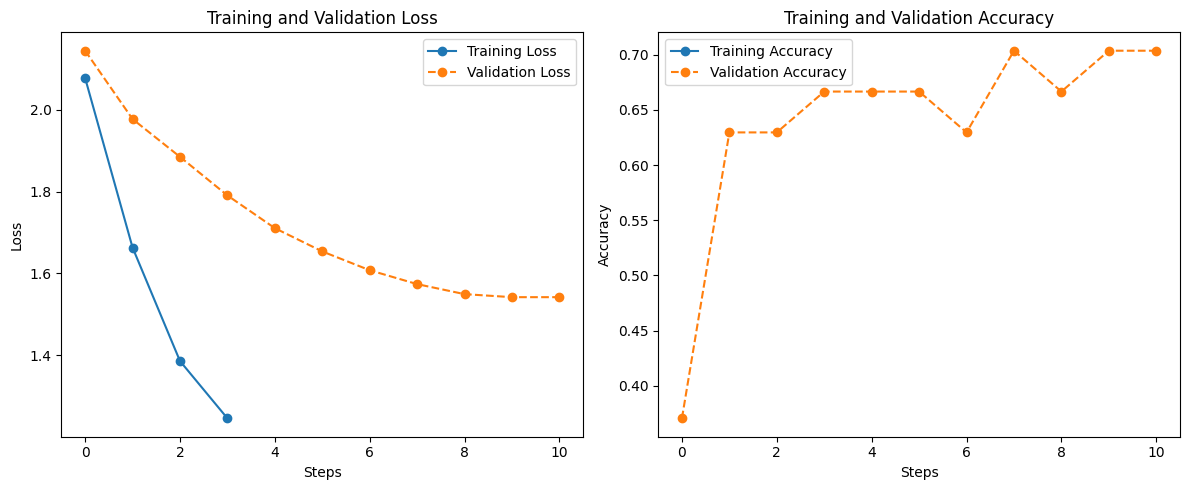

In [43]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label, class_dir in enumerate(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for fname in os.listdir(class_path):
                    file_path = os.path.join(class_path, fname)
                    if os.path.isfile(file_path):
                        self.image_paths.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the dataset
dataset = CustomDataset(root_dir='/content/drive/MyDrive/characters', transform=transform)

# Split the dataset into training and validation sets
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load Vision Transformer model and image processor
model_name = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(set(dataset.labels)))
image_processor = ViTImageProcessor.from_pretrained(model_name)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define custom Trainer callback
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.train_accuracies = []
        self.eval_losses = []
        self.eval_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        logs = logs or {}
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if 'accuracy' in logs:
            self.train_accuracies.append(logs['accuracy'])
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])
        if 'eval_accuracy' in logs:
            self.eval_accuracies.append(logs['eval_accuracy'])

# Initialize the callback
metrics_callback = MetricsCallback()

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
)

# Define a custom data collator function
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": images, "labels": labels}

# Define the compute metrics function
def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=-1)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    callbacks=[metrics_callback]
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print("Validation results:", eval_results)

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(metrics_callback.train_losses, label='Training Loss', marker='o')
plt.plot(metrics_callback.eval_losses, label='Validation Loss', marker='o', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(metrics_callback.train_accuracies, label='Training Accuracy', marker='o')
plt.plot(metrics_callback.eval_accuracies, label='Validation Accuracy', marker='o', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [44]:
# Specify the correct checkpoint path
checkpoint_path = './results/checkpoint-40'  # Replace <step> with the correct checkpoint step

model = ViTForImageClassification.from_pretrained(checkpoint_path, num_labels=len(set(dataset.labels)))


In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

# Train the model
trainer.train()

# Save the model
trainer.save_model()  # This saves the model in `output_dir`


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.454231,0.814815
2,No log,1.405838,0.666667
3,1.183300,1.316253,0.851852
4,1.183300,1.278152,0.851852
5,0.915000,1.231591,0.740741
6,0.915000,1.192762,0.814815
7,0.915000,1.154078,0.851852
8,0.752700,1.141110,0.851852
9,0.752700,1.139682,0.814815
10,0.684500,1.132982,0.814815


# TrOCR TRANSFORMER BASED OCR


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


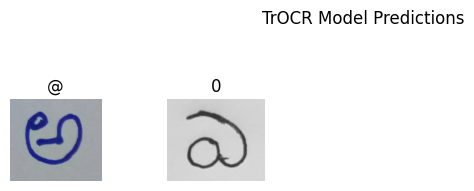

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Load the processor and model
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

# Function to predict text from an image
def predict_text(image):
    # Preprocess the image
    pixel_values = processor(images=image, return_tensors="pt").pixel_values

    # Generate the predictions
    generated_ids = model.generate(pixel_values)

    # Decode the predictions to text
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text

# Visualization of predictions
def visualize_predictions(images):
    plt.figure(figsize=(10, 9))
    plt.subplots_adjust(hspace=0.5)
    for n, image in enumerate(images):
        plt.subplot(6, 5, n + 1)
        plt.imshow(image)
        predicted_text = predict_text(image)
        plt.title(predicted_text)
        plt.axis('off')

    _ = plt.suptitle("TrOCR Model Predictions")
    plt.show()

# Example usage
image_paths = ['/content/drive/MyDrive/characters/Ic_a/1.png', '/content/drive/MyDrive/characters/Ic_ye/11.png']  # Replace with your image paths
images = [Image.open(image_path) for image_path in image_paths]

# Visualize the predictions
visualize_predictions(images)


**TrOCR couldn't recognize text**

## **Clearly, Resnet is the best model in terms of accuracy and performance. Though Vision Transformer being the most advanced technique in Computer Vision, it took lot of time to train the data and fetched less accuracy.**